In [1]:
%config Completer.use_jedi = False

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Exploretory Data Analysis

### To-Do
- Zusammenhang zwischen 5 Sterne und Review Count
- Bei jedem Review ein von jeder Sorte hinzufügen für fairen durchschnitt
- Daten auf Karte plotten
- Durchschnitte Median Mode berechnen für verschiedene Orte
- Preis durch Rating teilen teuer ==  besser bewertet?
- Art der Restaurant italienisch usw. (auch nach Region)
- Art mit Bewertung vergleichen
- Art mit Preis
- Anzahl der Kategorien = besser bewertet mehr Auswahl

- Öffnungszeiten rechnen und gesamtzeit

In [22]:
df = pd.read_csv('vancouver_yelp_restaurants.csv')
# Enthält keine Werte
df.drop(columns="Open24Hours", inplace=True)
# Nur Restaurants in British Columbia, Kanada (BC)
df = df[df["state"].str.lower() == "bc"]
# Wie viele Kategorien werden angegeben
df['categories_len'] = df["categories"].apply(lambda x: len(x.split(',')))

In [23]:
df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_fair,stars,...,BYOBCorkage,DietaryRestrictions,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,categories_len
0,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.485632,3.5,...,NaN,NaN,17:0-21:0,17:0-21:0,17:0-21:0,17:0-21:0,17:0-21:0,17:0-21:0,17:0-21:0,2
2,jfDfHzAq6iKkRnzzZ4n1nQ,Let's Roll Custom Sushi Bar,"1184 Denman Street, Suite 104",Vancouver,BC,V6G 2M9,49.286360,-123.140261,4.291667,4.5,...,NaN,NaN,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,4
4,OfA_4cHgvlknHMcn0qNs2w,Little Caesars,7010 Kerr Street,Vancouver,BC,V5S,49.219532,-123.040893,1.714286,1.0,...,NaN,NaN,11:0-23:0,11:0-23:0,11:0-23:0,11:0-23:0,11:0-23:0,11:0-23:0,11:0-23:0,2
5,7ee6XyKyeduI-Rbc6L5j2Q,NingTu Restaurant,2130 Kingsway,Vancouver,BC,V5N 2T5,49.244079,-123.063337,3.923077,4.0,...,NaN,NaN,17:30-21:30,17:30-21:30,NaN,17:30-21:30,17:30-21:30,17:30-21:30,17:30-21:30,2
6,r-hWf-bd9im5rj_l2MeofQ,Take Five Café,102-609 Granville Street,Vancouver,BC,V7Y 1H4,49.283532,-123.117107,3.772727,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [24]:
df.describe()

,latitude,longitude,stars_fair,stars,review_count,is_open,categories_len
count,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000
mean,49.267385,-123.116757,3.434624,3.510755,69.228197,0.575637,4.369418
std,0.019431,0.038054,0.535762,0.663953,115.464306,0.494304,2.200026
min,49.194305,-123.261752,1.312500,1.000000,5.000000,0.000000,1.000000
25%,49.260897,-123.134645,3.000000,3.000000,14.000000,0.000000,3.000000
50%,49.271543,-123.118398,3.458333,3.500000,33.000000,1.000000,4.000000
75%,49.281745,-123.100757,3.888889,4.000000,76.000000,1.000000,6.000000
max,49.351517,-123.022436,4.949749,5.000000,2302.000000,1.000000,16.000000


In [25]:
df[df["categories_len"] == 16]["categories"]

3003    Bars, Nightlife, Canadian (New), Comfort Food,...
Name: categories, dtype: object

In [6]:
df.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars_fair', 'stars', 'review_count',
       'is_open', 'attributes', 'categories', 'hours', 'GoodForKids',
       'Alcohol', 'RestaurantsGoodForGroups', 'RestaurantsReservations',
       'BusinessParking', 'RestaurantsAttire', 'BikeParking',
       'RestaurantsPriceRange2', 'HasTV', 'NoiseLevel', 'WiFi',
       'RestaurantsTakeOut', 'Caters', 'OutdoorSeating', 'Ambience',
       'GoodForMeal', 'DogsAllowed', 'RestaurantsDelivery',
       'BusinessAcceptsCreditCards', 'ByAppointmentOnly', 'Corkage',
       'RestaurantsTableService', 'WheelchairAccessible', 'HappyHour', 'BYOB',
       'Smoking', 'CoatCheck', 'Music', 'BestNights', 'DriveThru',
       'GoodForDancing', 'BYOBCorkage', 'DietaryRestrictions', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
      dtype='object')

<AxesSubplot:>

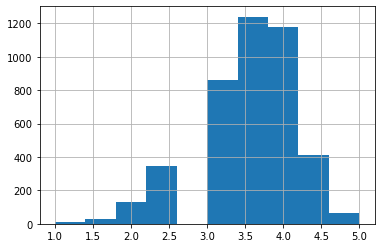

In [7]:
df.stars.hist()

<AxesSubplot:>

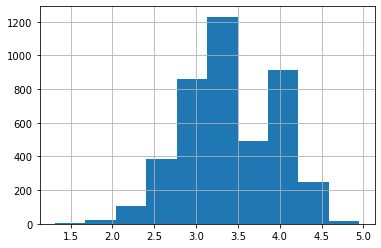

In [8]:
df.stars_fair.hist()

<AxesSubplot:>

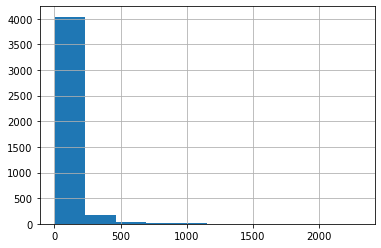

In [9]:
df.review_count.hist()

<AxesSubplot:>

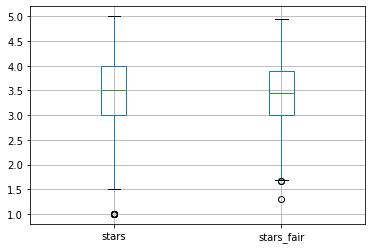

In [10]:
df.boxplot(column=["stars", "stars_fair"])

<AxesSubplot:>

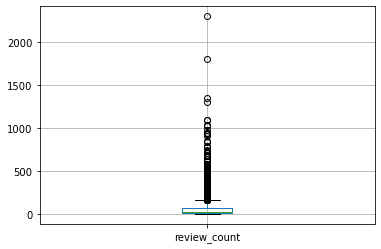

In [11]:
df.boxplot(column="review_count")

In [12]:
df["stars"].median()
df["stars"].mode()

df["review_count"].median()
df["review_count"].mode()

0    5
dtype: int64

<AxesSubplot:>

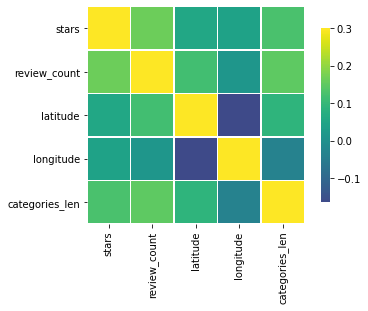

In [41]:
cmap = sns.color_palette("viridis", as_cmap=True)
sns.heatmap(df[["stars", "review_count",'latitude', 'longitude', 'categories_len']].corr(), vmax=.3, center=0,
            cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": 0.8})